# Matching to Long-Running Patterns
We have a few peaks which are tracked across the entire measurement well.
This notebook joins disconnected tracks by finding those which follow similar dynamics to the peaks which are tracked well.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np

## Load Tracks
Start from where we determined it based on the polynomial projection

In [2]:
peak_data = pd.read_csv('../0_explore-trackpy/tracks/polynomial-predict-tracks.csv')

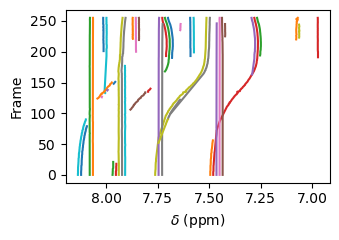

In [3]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), sharex=True)
for _, track in peak_data.groupby('particle'):
    ax.plot(track['offset'], track['frame'], '-')
    
ax.set_ylabel('Frame')

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel('$\delta$ (ppm)')

fig.tight_layout()
fig.savefig('figures/identified-prototypes.png', dpi=320)

We should be able to detect some tracks as extensions of others

## Find our longest tracks
Use an agglomerative technique where we start with the longest tracks and then make a library of those which do not align.

In [4]:
peaks_by_length = peak_data.groupby('particle').apply(len).sort_values(ascending=False).index

In [5]:
prototype_tracks = []
peak_data['proto_id'] = None
peak_data['is_prototype'] = False
for particle in peaks_by_length:
    track = peak_data.query(f'particle=={particle}')
    if len(track) < 8:
        continue
    
    # Score agreement with each prototype track
    # Measure by the deviation in the offset as a function of time
    proto_match = []
    for proto_id, proto_track in enumerate(prototype_tracks):
        joined = track.join(
            proto_track,
            on='frame', how='inner',
            lsuffix='_x', rsuffix='_y'
        )
        offset_diff = joined['offset_x'] - joined['offset_y']
        median_diff = offset_diff.median()
        match = (offset_diff - median_diff).abs().median()
        proto_match.append(match)
            
    # Find the best
    matched_proto_id = None
    if len(prototype_tracks) > 0 and min(proto_match) < 0.005:
        matched_proto_id = np.argmin(proto_match)
    
    # If not matched, add a new point to the library
    if matched_proto_id is None and len(track) > 100:
        peak_data.loc[track.index, 'proto_id'] = len(prototype_tracks)
        peak_data.loc[track.index, 'is_prototype'] = True
        prototype_tracks.append(track)
print(f'Found {len(prototype_tracks)} prototype tracks')

Found 3 prototype tracks


## Use these Prototypes to Further Link Trajectories
Starting with the longest tracks: match to a prototype, use that to estimate the movement of a peak, determine if any of the other segments match it. 

Start by making spline fits to the prototype tracks

In [6]:
prototype_splines = [UnivariateSpline(track['frame'][::-1], track['offset'][::-1], s=0.001) for track in prototype_tracks]

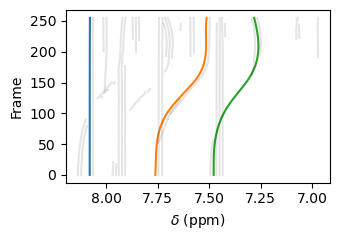

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), sharex=True)

x = np.arange(256)
for spline in prototype_splines:
    ax.plot(spline(x), x, '-', lw=1.5)
    
for _, track in peak_data.query('not is_prototype').groupby('particle'):
    ax.plot(track['offset'], track['frame'], '-', color='k', alpha=0.1)
    
ax.set_ylabel('Frame')

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel('$\delta$ (ppm)')

fig.tight_layout()
fig.savefig('figures/identified-prototypes.png', dpi=320)

In [8]:
any_matches = True
while any_matches:
    any_matches = False
    for ind, peak_id in enumerate(peaks_by_length):
        # Get the track to be matched
        track = peak_data.query(f'particle=={peak_id}')
        if len(track) < 8 or track['is_prototype'].any():
            continue
            
        # Score its overlap with prototype peaks
        best_match_score = np.inf
        best_match_track = None
        best_match_offset = None
        for spline in prototype_splines:
            # Batches match if they have a constant offset between each other
            pred_offset = spline(track.frame)
            delta_offset = track['offset'] - pred_offset
            score = delta_offset.std()
            if best_match_score > score:
                best_match_track = spline
                best_match_score = score
                best_match_offset = delta_offset.mean()
                
        # See if any of the shorter tracks match
        for short_track_id in peaks_by_length[ind+1:]:
            short_track = peak_data.query(f'particle=={short_track_id}')
            
            # Skip if this shorter track and our track exist in the same frames
            overlap_frames = set(short_track.frame.values).intersection(track.frame.values)
            if len(overlap_frames) > 0:
                continue
            
            expected_track = best_match_track(short_track.frame) + best_match_offset
            offset_difference = (expected_track - short_track.offset).abs().mean()
            if offset_difference > 0.01:
                continue
                
            # Update particle ID of the short track
            peak_data.loc[short_track.index, 'particle'] = peak_id
            peak_data.sort_values(['particle', 'frame'], inplace=True)
            

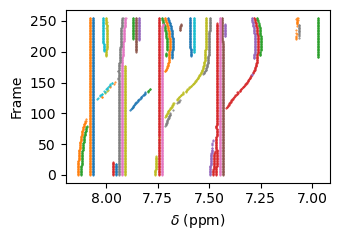

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), sharex=True)

for _, subtrack in peak_data.groupby('particle'):
    ax.plot(subtrack['offset'], subtrack['frame'], '.', ms=1)
    
ax.set_ylabel('Frame')

ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel('$\delta$ (ppm)')

fig.tight_layout()
fig.savefig('figures/identified-prototypes.png', dpi=320)

We do a _better_ job of connecting disconnected tracks.